# GAN-based Fake Image Generation with Keras & TensorFlow

This notebook implements a simple Generative Adversarial Network (GAN) using Keras and TensorFlow to generate fake images that resemble real MNIST digits. The notebook includes: problem statement, algorithm description, model implementations (Generator and Discriminator), training loop (recommended 400 epochs), generated image plots at milestones, and discussion/analysis.

## Problem statement
Fake images are now common on social media. This project aims to help students understand how such images are synthesized using a GAN. We'll build and train a GAN on the MNIST digits dataset so the Generator learns to produce digit-like images and the Discriminator learns to tell real from fake.

## Algorithm (high-level)
1. Build a Generator network that maps random noise vectors (100-dim) to 28x28 grayscale images.
2. Build a Discriminator network that takes 28x28 images and outputs real/fake probability.
3. Train by alternating: train Discriminator on real and generated images, then train Generator via the combined GAN model to fool the Discriminator.
4. Periodically sample the Generator and plot images to see progress (epochs: 1, 30, 100, 200, 400).

In [1]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, datasets

# Print versions for reproducibility
print('TensorFlow version:', tf.__version__)
print('Keras version:', keras.__version__)
print('NumPy version:', np.__version__)

TensorFlow version: 2.20.0
Keras version: 3.11.3
NumPy version: 1.26.4


## Utility: Build Generator and Discriminator
The generator will use Dense layers, LeakyReLU activations, and BatchNormalization, producing tanh outputs (so we'll rescale real images to [-1,1]). The discriminator will also use LeakyReLU and BatchNormalization as requested.

In [2]:
def build_generator(noise_dim=100):
    # Simple fully-connected generator mapping noise -> 28*28 image
    model = keras.Sequential(name='Generator')
    model.add(layers.Input(shape=(noise_dim,)))
    # Layer 1
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())
    # Layer 2
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())
    # Layer 3
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())
    # Output layer -> 28*28 with tanh activation (range [-1,1])
    model.add(layers.Dense(28 * 28, activation='tanh'))
    model.add(layers.Reshape((28, 28, 1)))
    return model

def build_discriminator(input_shape=(28,28,1)):
    # Simple fully-connected discriminator mapping image -> probability
    model = keras.Sequential(name='Discriminator')
    model.add(layers.Input(shape=input_shape))
    model.add(layers.Flatten())
    # Layer 1
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())
    # Layer 2
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())
    # Layer 3
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())
    # Output probability
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

# Instantiate models and show summaries (brief)
noise_dim = 100
generator = build_generator(noise_dim=noise_dim)
discriminator = build_discriminator()
generator.summary()
discriminator.summary()

/Users/alexmartinez/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 784)            │       803,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 28, 28, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,493,520 (5.70 MB)

 Trainable params: 1,489,936 (5.68 MB)

 Non-trainable params: 3,584 (14.00 KB)

Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │       803,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,467,393 (5.60 MB)

 Trainable params: 1,463,809 (5.58 MB)

 Non-trainable params: 3,584 (14.00 KB)

## Compile models and build the stacked GAN
We'll compile the Discriminator separately and then create the combined model (Generator -> Discriminator) with the Discriminator set as non-trainable for Generator updates.

In [3]:
# Optimizers and loss
lr = 0.0002
beta_1 = 0.5
opt = keras.optimizers.Adam(learning_rate=lr, beta_1=beta_1)

# Compile discriminator
discriminator.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Build GAN: stack generator and discriminator
discriminator.trainable = False  # freeze during generator training
gan_input = layers.Input(shape=(noise_dim,))
gan_output = discriminator(generator(gan_input))
gan = models.Model(inputs=gan_input, outputs=gan_output, name='GAN')
gan.compile(optimizer=opt, loss='binary_crossentropy')
gan.summary()

Model: "GAN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Generator (Sequential)          │ (None, 28, 28, 1)      │     1,493,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Discriminator (Sequential)      │ (None, 1)              │     1,467,393 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,960,913 (11.29 MB)

 Trainable params: 1,489,936 (5.68 MB)

 Non-trainable params: 1,470,977 (5.61 MB)

## Helper: plotting generated images from noise
A convenience function to sample the generator and show a grid of generated digits. The generator outputs are in [-1,1] (tanh), so we rescale to [0,1] for plotting.

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


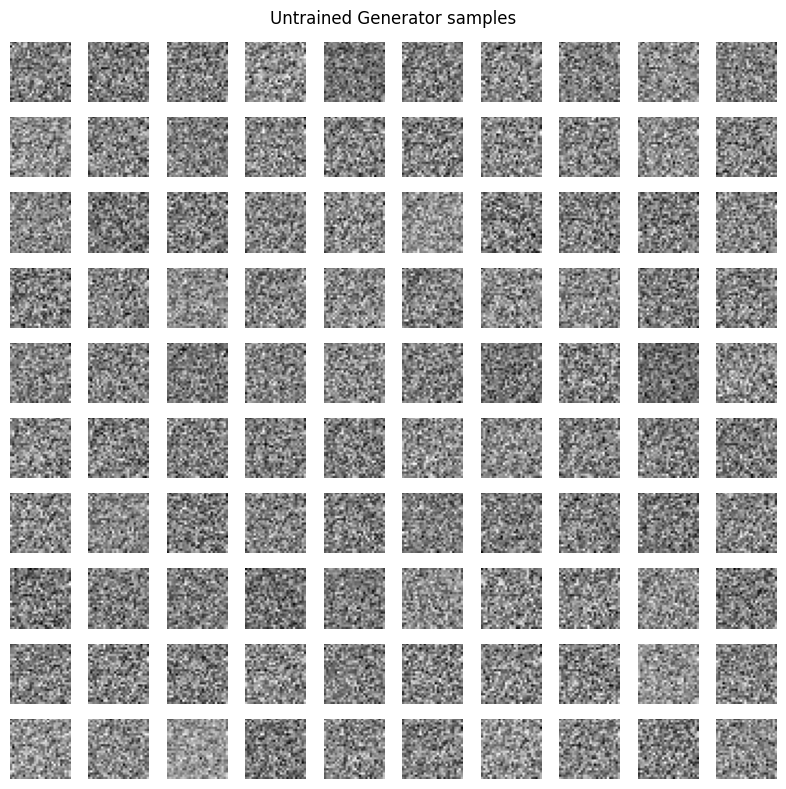

In [4]:
def plot_generated_images(generator, noise_input, figsize=(6,6), cmap='gray', title=None, save_path=None):
    # noise_input: array of shape (n, noise_dim)
    gen_images = generator.predict(noise_input)  # shape (n,28,28,1)
    # Rescale from [-1,1] to [0,1]
    gen_images = (gen_images + 1.0) / 2.0
    n = gen_images.shape[0]
    side = int(np.sqrt(n))
    fig, axes = plt.subplots(side, side, figsize=figsize)
    idx = 0
    for i in range(side):
        for j in range(side):
            ax = axes[i,j]
            ax.imshow(gen_images[idx, :, :, 0], cmap=cmap)
            ax.axis('off')
            idx += 1
    if title:
        plt.suptitle(title)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

# Quick test: generate a 10x10 grid of images from random noise (won't be meaningful until trained)
sample_noise = np.random.normal(0, 1, (100, noise_dim))
# Plot (note: generator is untrained now so these look like noise)
plot_generated_images(generator, sample_noise, figsize=(8,8), title='Untrained Generator samples')

## Prepare dataset (MNIST) and preprocessing
We load MNIST from Keras datasets, normalize pixel values to [-1,1] (because generator uses tanh), and set up training data.

In [5]:
# Load MNIST
(x_train, _), (_, _) = datasets.mnist.load_data()
# Normalize to [-1,1] and add channel dimension
x_train = (x_train.astype('float32') - 127.5) / 127.5  # now in [-1,1]
x_train = np.expand_dims(x_train, axis=-1)  # shape (60000,28,28,1)
print('x_train shape:', x_train.shape, 'min/max:', x_train.min(), x_train.max())

x_train shape: (60000, 28, 28, 1) min/max: -1.0 1.0


## Training function
The training function alternates between updating the Discriminator (on real and fake batches) and the Generator (via the GAN). We'll save images at milestone epochs for inspection. Training 400 epochs on full MNIST may take a long time on CPU; GPU is recommended.

In [6]:
def train_gan(generator, discriminator, gan, data, noise_dim=100, epochs=400, batch_size=128, milestones=None, out_dir='gan_outputs'):
    os.makedirs(out_dir, exist_ok=True)
    half_batch = batch_size // 2
    # Prepare fixed noise for consistent sampling across epochs
    fixed_noise = np.random.normal(0, 1, (100, noise_dim))
    # Milestones default
    if milestones is None:
        milestones = [1, 30, 100, 200, 400]

    # Labels
    real_label = np.ones((half_batch, 1))
    fake_label = np.zeros((half_batch, 1))

    batches_per_epoch = data.shape[0] // batch_size

    history = {'d_loss': [], 'g_loss': [], 'd_acc': []}

    for epoch in range(1, epochs + 1):
        d_losses = []
        d_accs = []
        g_losses = []
        # Shuffle data at each epoch
        idx = np.random.permutation(data.shape[0])
        data_shuffled = data[idx]

        for batch in range(batches_per_epoch):
            start = batch * batch_size
            end = start + half_batch
            # ---------------------
            # Train Discriminator on real images
            real_imgs = data_shuffled[start:end]
            d_loss_real = discriminator.train_on_batch(real_imgs, real_label)
            # ---------------------
            # Train Discriminator on fake images
            noise = np.random.normal(0, 1, (half_batch, noise_dim))
            gen_imgs = generator.predict(noise)
            d_loss_fake = discriminator.train_on_batch(gen_imgs, fake_label)
            # Average discriminator loss & acc
            # Keras train_on_batch returns [loss, acc] for compiled models with metrics
            if isinstance(d_loss_real, list):
                d_loss = 0.5 * (d_loss_real[0] + d_loss_fake[0])
                d_acc = 0.5 * (d_loss_real[1] + d_loss_fake[1])
            else:
                d_loss = 0.5 * (d_loss_real + d_loss_fake)
                d_acc = 0.0
            d_losses.append(d_loss)
            d_accs.append(d_acc)
            # ---------------------
            # Train Generator via GAN (labels are real because we want generator to trick discriminator)
            noise2 = np.random.normal(0, 1, (batch_size, noise_dim))
            g_loss = gan.train_on_batch(noise2, np.ones((batch_size, 1)))
            g_losses.append(g_loss)

        # epoch metrics
        epoch_d_loss = np.mean(d_losses)
        epoch_d_acc = np.mean(d_accs) if d_accs else None
        epoch_g_loss = np.mean(g_losses)
        history['d_loss'].append(epoch_d_loss)
        history['d_acc'].append(epoch_d_acc)
        history['g_loss'].append(epoch_g_loss)

        # Print progress small summary
        if epoch % 10 == 0 or epoch in milestones:
            print(f'Epoch {epoch}/{epochs}  D_loss={epoch_d_loss:.4f}  G_loss={epoch_g_loss:.4f}  D_acc={epoch_d_acc:.4f}')

        # Save images at milestones
        if epoch in milestones:
            out_path = os.path.join(out_dir, f'epoch_{epoch}.png')
            plot_generated_images(generator, fixed_noise, figsize=(6,6), title=f'Generated at epoch {epoch}', save_path=out_path)

    return history

## Run training (note: heavy compute)
Run the cell below to start training. This will train for 400 epochs by default and save sample images at the milestone epochs (1, 30, 100, 200, 400) in the `gan_outputs` folder.
**Important:** Training 400 epochs on CPU will be slow; use a GPU runtime if possible.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━

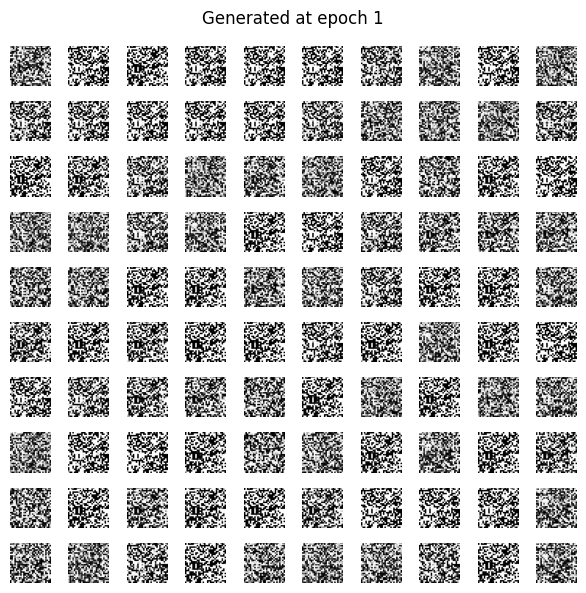

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━

In [9]:
# Uncomment the following line to train the GAN. Training 400 epochs can be long; for quick tests use epochs=10 or 20.
# history = train_gan(generator, discriminator, gan, x_train, noise_dim=noise_dim, epochs=400, batch_size=128)
print('Training cell included but commented out to avoid accidental long runs. Uncomment to train.')

Generator found in memory — sampling 100 images...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


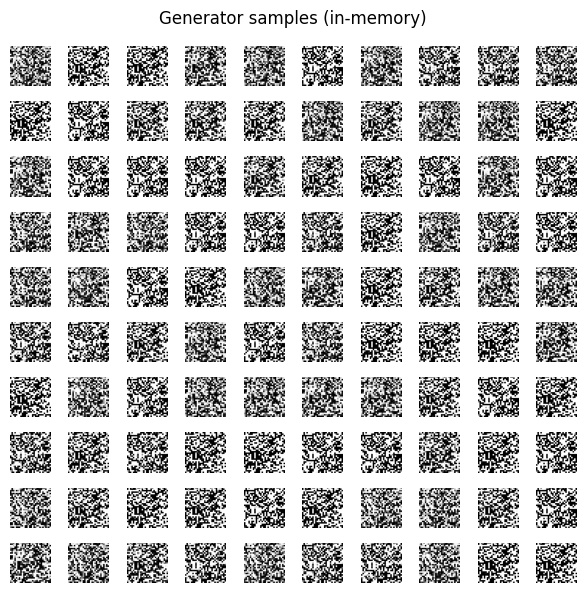

In [10]:
# Use the trained generator if available in memory; otherwise show the latest saved sample image from gan_outputs/
import glob
# If the notebook session still has the generator object, sample from it and display images inline.
if 'generator' in globals():
    print('Generator found in memory — sampling 100 images...')
    fixed_noise = np.random.normal(0, 1, (100, noise_dim))
    plot_generated_images(generator, fixed_noise, figsize=(6,6), title='Generator samples (in-memory)')
else:
    # Try to find saved sample images produced during training
    imgs = glob.glob('gan_outputs/epoch_*.png')
    if imgs:
        # pick the latest epoch image by sorting filenames
        latest = sorted(imgs, key=lambda x: int(x.split('_')[-1].split('.')[0]))[-1]
        from PIL import Image
        im = Image.open(latest)
        plt.figure(figsize=(6,6))
        plt.imshow(im)
        plt.axis('off')
        plt.title(f'Showing latest saved sample: {latest}')
        plt.show()
    else:
        print('No generator in memory and no saved sample images found. Train the model or run a quick test run to generate samples.')
# Optional: to persist the generator to disk for later use, uncomment below:
# if 'generator' in globals(): generator.save('generator.h5')

## Analysis & Findings
After training for the full 400 epochs (or fewer for quick experiments), inspect the saved images in `gan_outputs/epoch_X.png`. Expected observations: 
- Early epochs (1-10): outputs are noise-like.
- Mid epochs (30-100): coarse digit shapes start to appear; generator learns global structure.
- Later epochs (200-400): digits should become clearer and sharper, although with this simple fully-connected architecture, images might be blurrier compared to convolutional GANs (DCGAN).

Quantitative evaluation: simple GAN training often reports losses for D and G, but loss values alone are not a reliable indicator of visual quality. More advanced metrics (Inception Score, FID) require additional models and are not included here. For this assignment, visual inspection at milestone epochs is acceptable and educational.

## Shortcomings & Improvements
- The model uses fully-connected layers; replacing with convolutional (DCGAN) architecture yields much better images.
- Training stability: add label smoothing, use Wasserstein GAN or spectral normalization for improved stability.
- Larger architectures, longer training, and GPU accelerate improvements.

## References
- Goodfellow et al., 2014. Generative Adversarial Nets.
- Radford et al., 2015. Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks (DCGAN).
- TensorFlow Keras documentation: https://www.tensorflow.org/guide/keras
- Keras examples: GANs (https://keras.io/examples/generative/dcgan/)

## How to run / Notes
1. Open this notebook in Jupyter or JupyterLab.
2. If you have a GPU, enable it for much faster training. On Colab choose Runtime > Change runtime type > GPU.
3. Optionally run a short test with epochs=10 to validate code and see quick progress. Then run the full 400-epoch training if desired.
4. Saved sample images will be in the `gan_outputs` folder in the same directory as the notebook.